In [9]:
import os
import cv2
import numpy as np
from tqdm import tqdm


In [20]:
class HandSign():
    IMG_SIZE=28
    LABELS={'Dang':0,'Fist':1,'Four':2,'Palm':3,'Startrek':4}
    training_data=[]    
    count=[0,0,0,0,0]
    
    def make_training_data(self):
        for fold in self.LABELS:
            for subfold in os.listdir(fold):
                for pic_name in tqdm(os.listdir(os.path.join(fold,subfold))):

                    if "png" in pic_name:
                        try:
                            path=os.path.join(fold,subfold,pic_name)
                            img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                            img=cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                            self.training_data.append([np.array(img),np.eye(5)[self.LABELS[fold]]])                    
                            self.count[self.LABELS[fold]]+=1
                    
                        except Exception as e:
                            pass
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print(self.count)
    
            
handsign=HandSign()   
handsign.make_training_data()
    

100%|████████████████████████████████████████████████████████████████████████████| 1351/1351 [00:01<00:00, 1007.57it/s]


[3123, 3641, 3682, 3882, 4208]


<function matplotlib.pyplot.show(*args, **kw)>

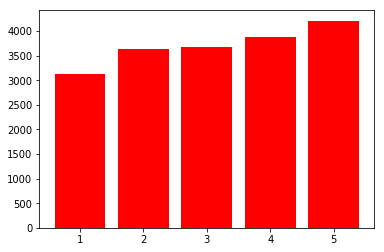

In [32]:
from matplotlib import pyplot as plt
plt.bar([1,2,3,4,5],handsign.count,color='red')
plt.show

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

training_data=np.load("training_data.npy")

In [43]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,3)
        self.conv2=nn.Conv2d(32,64,3)
        self.conv3=nn.Conv2d(64,128,3)

        x=torch.randn(28,28).view(-1,1,28,28)
        self.to_linear=None
        self.convs(x)
        
        self.fc1=nn.Linear(self.to_linear,512)
        self.fc2=nn.Linear(512,5)
            
        
    def convs(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        if self.to_linear is None:
            self.to_linear=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return(x)
    
    def forward(self,x):
        x=self.convs(x)
        x=x.view(-1,self.to_linear)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        
        return F.softmax(x,dim=1)
    
net=Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [54]:
import torch.optim as optim

optimizer=optim.Adam(net.parameters(),lr=0.001)
loss_function=nn.MSELoss()

In [49]:
X=torch.Tensor([i[0] for i in tqdm(training_data)]).view(-1,28,28)
X=X/255.0
Y=torch.Tensor([i[1] for i in  tqdm(training_data)])

print(X.shape,Y.shape)

100%|███████████████████████████████████████████████████████████████████████| 18536/18536 [00:00<00:00, 1268177.46it/s]

torch.Size([18536, 28, 28]) torch.Size([18536, 5])


In [50]:
val_size=0.1
val_size=int(len(X)*val_size)

print(val_size)

1853


In [60]:
train_X=X[:-val_size]
train_Y=Y[:-val_size]

test_X=X[-val_size:]
test_Y=Y[-val_size:]

print(len(train_X),len(train_Y))

16683 16683


In [62]:
batch_size=50
EPOCHS=10

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X),batch_size)):
        batch_X=train_X[i:i+batch_size].view(-1,1,28,28)
        batch_Y=train_Y[i:i+batch_size]
        
        net.zero_grad()
        
        outputs=net(batch_X)
        loss=loss_function(outputs,batch_Y)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch:{epoch}. Loss:{loss}")

  1%|▋                                                                                 | 3/334 [00:00<00:15, 20.98it/s]

Epoch:0. Loss:0.0006873628590255976


  1%|▋                                                                                 | 3/334 [00:00<00:15, 20.98it/s]

Epoch:1. Loss:0.00021637776808347553


  1%|▋                                                                                 | 3/334 [00:00<00:16, 20.42it/s]

Epoch:2. Loss:0.0007607925217598677


  1%|▍                                                                                 | 2/334 [00:00<00:16, 20.00it/s]

Epoch:3. Loss:0.0002485786098986864


  1%|▍                                                                                 | 2/334 [00:00<00:17, 19.40it/s]

Epoch:4. Loss:0.0015759989619255066


  1%|▍                                                                                 | 2/334 [00:00<00:16, 19.70it/s]

Epoch:5. Loss:0.00026779703330248594


  1%|▍                                                                                 | 2/334 [00:00<00:18, 18.33it/s]

Epoch:6. Loss:0.00012914442049805075


  1%|▍                                                                                 | 2/334 [00:00<00:19, 16.66it/s]

Epoch:7. Loss:9.31233080336824e-05


  1%|▍                                                                                 | 2/334 [00:00<00:17, 18.53it/s]

Epoch:8. Loss:2.1602072592941113e-05


100%|████████████████████████████████████████████████████████████████████████████████| 334/334 [00:18<00:00, 18.18it/s]

Epoch:9. Loss:8.31391298561357e-06


In [63]:
correct=0
total=0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real=torch.argmax(test_Y[i])
        net_out=net(test_X[i].view(-1,1,28,28))[0]
        predicted=torch.argmax(net_out)
        
        if predicted==real:
            correct+=1
        total+=1
print("Accuracy: ",100*round(correct/total,3))

100%|█████████████████████████████████████████████████████████████████████████████| 1853/1853 [00:02<00:00, 794.13it/s]

Accuracy:  99.9


(28, 28)


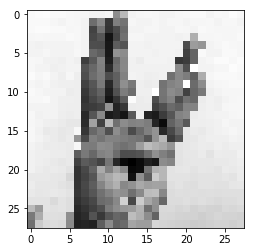

In [114]:
from matplotlib import pyplot as plt
img=cv2.imread("star.jpg",cv2.IMREAD_GRAYSCALE)
img=cv2.resize(img,(28,28))

plt.imshow(img,cmap='gray')
img=np.array(img)

print(img.shape)


In [116]:
with torch.no_grad():    
    img=torch.Tensor(img).view(-1,28,28)
    out=model(img.view(-1,1,28,28))[0]
    print(out)

tensor([0., 0., 0., 0., 1.])


In [112]:
torch.save(net,"full.pth")

c:\users\nahar\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [113]:
model=torch.load("full.pth")
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)